In [1]:
import mplpub
import numpy as np
from ase import Atoms
from ase.io import read
from ase.spacegroup.symmetrize import FixSymmetry
from ase.units import GPa, kB
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from matplotlib import pyplot as plt, colormaps
from pandas import DataFrame, read_json, concat as pd_concat
from phonopy import load, Phonopy, PhonopyQHA
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.units import Avogadro, EvTokJmol, kb_J, THzToEv
from seekpath import get_explicit_k_path
from tqdm import tqdm

R = kb_J * Avogadro
mplpub.setup(template='acs')

In [2]:
def get_props(
    ph, classical,
    mesh=[40, 40, 40],
    t_min=1, t_max=600, t_step=1,
    freq_min=-5, freq_max=20, freq_pitch=0.05,
):
    # evaluate frequencies on the specified q-point mesh
    ph.run_mesh(mesh)

    # compute thermal properties
    ph.run_thermal_properties(t_min=t_min, t_max=t_max, t_step=t_step, classical=classical)

    # turn results into DataFrame
    tp_dict = ph.get_thermal_properties_dict()
    df_thermo = DataFrame(tp_dict)
    df_thermo['temperature'] = df_thermo.temperatures
    del df_thermo['temperatures']

    # add columns with properties in more convenient units for plotting
    natoms = len(get_structure(ph))
    df_thermo['free_energy_eV'] = df_thermo.free_energy / EvTokJmol / natoms
    df_thermo['entropy_kB'] = df_thermo.entropy / R / natoms
    df_thermo['heat_capacity_kB'] = df_thermo.heat_capacity / R / natoms

    # density of states
    ph.run_total_dos(freq_min=freq_min, freq_max=freq_max, freq_pitch=freq_pitch)
    dos_dict = ph.get_total_dos_dict()
    df_dos = DataFrame(dos_dict)
    df_dos['frequency'] = df_dos.frequency_points
    del df_dos['frequency_points']
    df_dos.total_dos /= natoms

    return df_thermo, df_dos

In [3]:
def get_structure(phonon):
    structure_ph = phonon.primitive
    structure_ase = Atoms(symbols=structure_ph.symbols, cell=structure_ph.cell,
                          scaled_positions=structure_ph.scaled_positions, pbc=True)
    return structure_ase

In [4]:
def labels_to_latex(labels_in):
    labels = [r'$\UG{\Gamma}$' if m == 'GAMMA' else m for m in labels_in]
    labels = [m.replace('SIGMA', r'$\UG{\Sigma}$') if m.startswith('SIGMA') else m for m in labels]
    labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
    return labels

colors = {
    'BaZrS3-spg140-I4mcm': 'C0',
    'BaZrS3-spg62-Pnma': 'C1',
#    'BaZrS3-spg62-Pnma-DELTA': 'C2',
}

labels = {
    'BaZrS3-spg140-I4mcm': 'I4/mcm',
    'BaZrS3-spg62-Pnma': 'Pnma',
#    'BaZrS3-spg62-Pnma-DELTA': 'delta',
}

In [5]:
xc = 'HSE'
model_filename = 'nep.txt'
supercell_matrix = [4, 4, 4]

phonons = {}
for sname in labels:
    print(f'sname: {sname}')
    phonons[sname] = {}
    for volsc in tqdm(np.arange(0.92, 1.11, 0.01)):
        volsc = np.around(volsc, decimals=3)
        outfile = f'runs-{xc}/phonon-{sname}-volsc{volsc:.3f}.yaml'
        try:
            ph = load(outfile)
        except:
            structure = read(f'structures/{sname}.xyz')
            cell = structure.cell[:] * volsc ** (1 / 3)
            structure.set_cell(cell, scale_atoms=True)
            calculator = CPUNEP(model_filename)
            structure.calc = calculator
            structure.set_constraint(FixSymmetry(structure))
            relax_structure(structure, constant_volume=True)
            ph = get_force_constants(structure, calculator, supercell_matrix=supercell_matrix)
            ph.save(outfile)

        phonons[sname][volsc] = ph

sname: BaZrS3-spg140-I4mcm


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['rotations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['translations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


In [6]:
volsc = 1.0

paths = {}
dfs_phonons = {}
for sname in phonons:
    phonon = phonons[sname][volsc]

    structure = get_structure(phonon)
    structure_tuple = (structure.cell[:], structure.get_scaled_positions(), structure.numbers)
    path = get_explicit_k_path(structure_tuple)
    paths[sname] = path.copy()

    phonon.run_band_structure([path['explicit_kpoints_rel']])
    band = phonon.get_band_structure_dict()

    df = DataFrame(band['frequencies'][0])
    df.index = path['explicit_kpoints_linearcoord']
    dfs_phonons[sname] = df 

/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['transformation_matrix']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  w

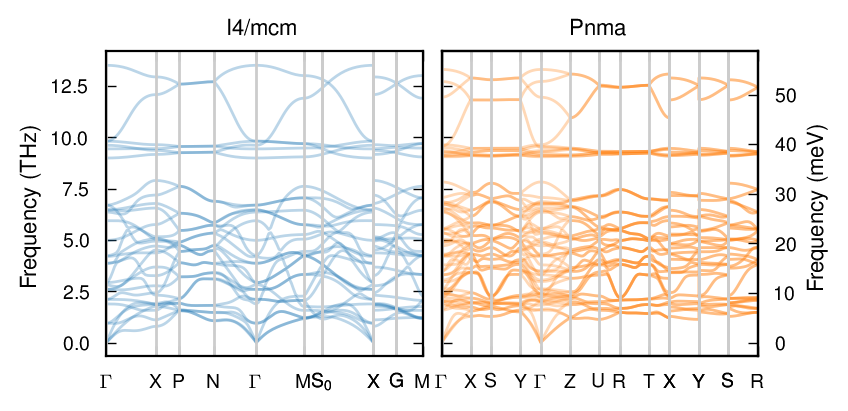

In [7]:
ncols = len(dfs_phonons)

fig, axes = plt.subplots(
    figsize=(4.2, 2.1),
    ncols=len(dfs_phonons),
    sharey=True,
    dpi=200,
)

for icol, (sname, df) in enumerate(dfs_phonons.items()):
    ax = axes[icol]
    path = paths[sname]

    ax.set_title(labels[sname])
    for col in df.columns:
        ax.plot(df.index, df[col], color=colors[sname], alpha=0.3)
    ax.set_xlim(df.index.min(), df.index.max())

    if icol == 0:
        ax.set_ylabel('Frequency (THz)')
    if icol == ncols - 1:
        ax2 = ax.twinx()
        ax2.set_ylabel('Frequency (meV)')
        ax2.set_ylim(THzToEv * 1e3 * np.array(ax.get_ylim()))

    qpts_labels = labels_to_latex(path['explicit_kpoints_labels'])
    df_path = DataFrame(dict(labels=qpts_labels,
                             positions=path['explicit_kpoints_linearcoord']))
    df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
    ax.set_xticks(df_path.positions)
    ax.set_xticklabels(df_path.labels)
    for xp in df_path.positions:
        ax.axvline(xp, color='0.8')

fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0.06) 

In [8]:
data = []
for sname in phonons:
    for volsc, ph in phonons[sname].items():
        structure = get_structure(ph)
        structure.calc = CPUNEP(model_filename)
        natoms = len(structure)
        energy = structure.get_potential_energy()
        stress = structure.get_stress() / GPa
        pressure = -np.sum(stress[:3])
        data.append(dict(
            sname=sname,
            natoms=natoms,
            volsc=volsc,
            energy=energy,
            energy_kJ=energy * EvTokJmol,
            volume=structure.get_volume(),
            pressure=pressure,
        ))
df_energies = DataFrame(data)

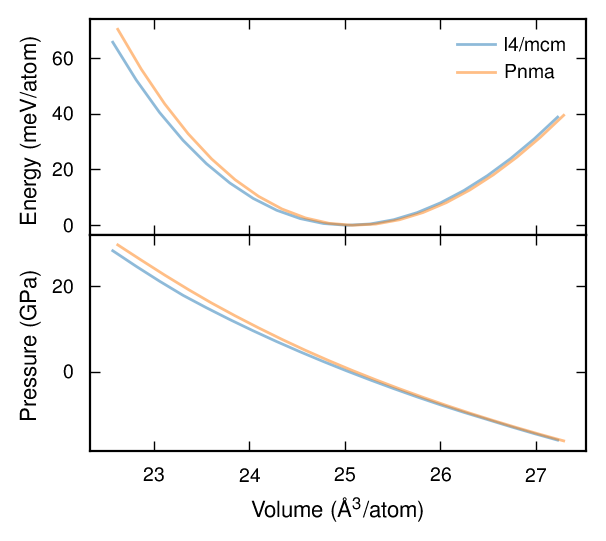

In [9]:
fig, axes = plt.subplots(
    figsize=(3.2, 2.8),
    dpi=200,
    nrows=2,
    sharex=True,
)

for sname, df in df_energies.groupby('sname'):
    kwargs = dict(
        alpha=0.5,
        label=labels[sname],
        color=colors[sname],
    )
    axes[0].plot(df.volume / df.natoms, 1e3 * (df.energy - df.energy.min()) / df.natoms, **kwargs)
    axes[1].plot(df.volume / df.natoms, df.pressure, **kwargs)

axes[0].set_ylabel('Energy (meV/atom)')
axes[1].set_ylabel('Pressure (GPa)')
axes[-1].set_xlabel('Volume (Å$^3$/atom)')

axes[0].legend()

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

In [10]:
dfs_thermo = {}
dfs_dos = {}
for classical in [True, False]:
    dfs_dos[classical] = {}
    dfs_thermo[classical] = {}
    label = 'classical' if classical else 'quantum'
    for sname in phonons:
        print(f'classical: {classical}   sname: {sname}')
        dfs_dos[classical][sname] = {}
        dfs_thermo[classical][sname] = {}
        for volsc, ph in tqdm(phonons[sname].items()):
            dosfile = f'runs-{xc}/dos-{sname}-volsc{volsc:.3f}-{label}.json'
            thermofile = f'runs-{xc}/thermo-{sname}-volsc{volsc:.3f}-{label}.json'
            try:
                dos = read_json(dosfile)
                thermo = read_json(thermofile)
            except:
                thermo, dos = get_props(ph, classical, t_min=1, t_max=600, t_step=1)
                thermo.to_json(thermofile)
                dos.to_json(dosfile)
            dfs_thermo[classical][sname][volsc] = thermo
            dfs_dos[classical][sname][volsc] = dos

classical: True   sname: BaZrS3-spg140-I4mcm


100%|██████████| 20/20 [00:00<00:00, 257.44it/s]


classical: True   sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [00:00<00:00, 279.72it/s]


classical: False   sname: BaZrS3-spg140-I4mcm


100%|██████████| 20/20 [00:00<00:00, 291.89it/s]


classical: False   sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [00:00<00:00, 288.53it/s]


volmin: 0.920   volmax: 1.100
volmin: 0.920   volmax: 1.110


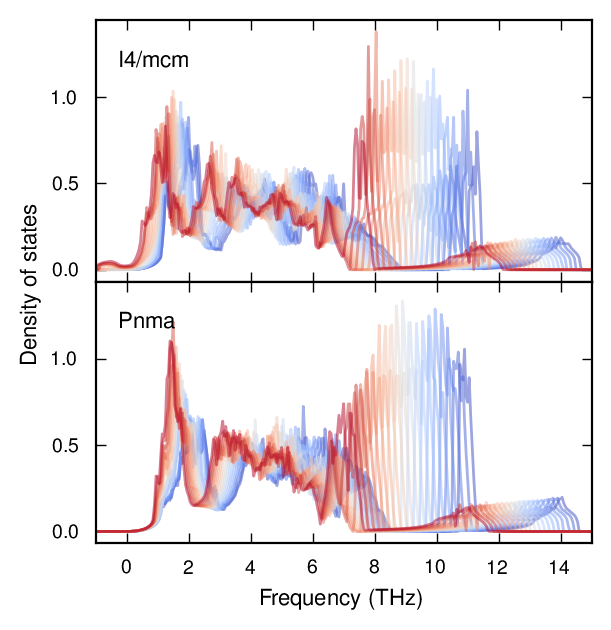

In [11]:
fig, axes = plt.subplots(
    figsize=(3.2, 3.4),
    dpi=200,
    nrows=len(dfs_dos[True]),
    sharex=True,
    sharey=True,
)

cmap = colormaps['coolwarm']
classical = True

volsc_limits = {
    'BaZrS3-spg140-I4mcm': (0.9, 1.1),
    'BaZrS3-spg62-Pnma': (0.9, 1.3)
}

for k, sname in enumerate(dfs_dos[classical]):
    axes[k].text(0.05, 0.82, labels[sname], transform=axes[k].transAxes)
    volmin, volmax = volsc_limits[sname]
    volmin = max(volmin, np.min(list(dfs_dos[classical][sname].keys())))
    volmax = min(volmax, np.max(list(dfs_dos[classical][sname].keys())))
    print(f'volmin: {volmin:.3f}   volmax: {volmax:.3f}')
    for volsc, df in dfs_dos[classical][sname].items():
        if volsc < volmin or volsc > volmax:
            continue
        df = df[df.frequency < 20]
        xrel = (volsc - volmin) / (volmax - volmin)
        kwargs = dict(
            alpha=0.5,
            color=cmap(xrel),
        )
        axes[k].plot(df.frequency, df.total_dos, **kwargs)

ax = axes[-1]
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Density of states', y=1)
ax.set_xlim(-1, 15)

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

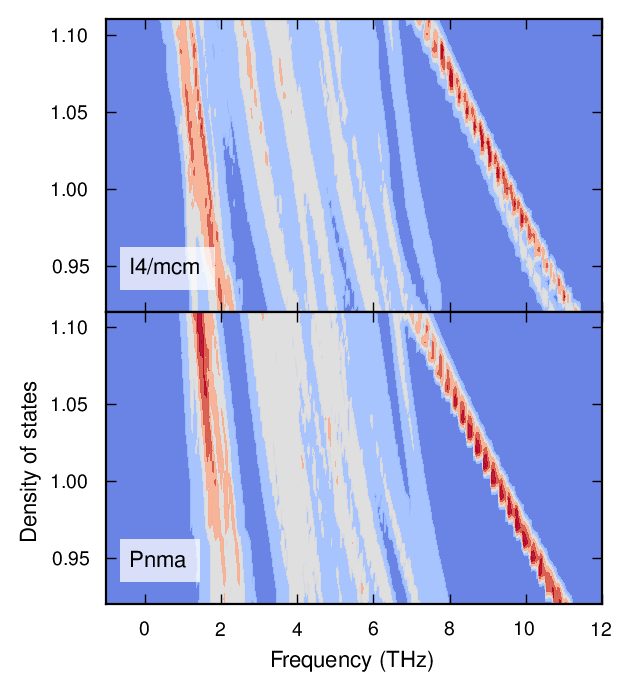

In [12]:
fig, axes = plt.subplots(
    figsize=(3.2, 3.8),
    dpi=200,
    nrows=len(dfs_dos[True]),
    sharex=True,
    sharey=True,
)

classical = True
for k, sname in enumerate(dfs_dos[classical]):
    df_dos = DataFrame()
    for volsc, df in dfs_dos[classical][sname].items():
        df['volsc'] = volsc
        df_dos = pd_concat([df_dos, df], ignore_index=True)

    ax = axes[k]
    ax.text(0.05, 0.13, labels[sname], transform=ax.transAxes, bbox=dict(lw=0, color='white', alpha=0.75))
    df_dos = df_dos[df_dos.frequency < 12]
    ax.tricontourf(df_dos.frequency, df_dos.volsc, df_dos.total_dos,
                   alpha=0.9, vmin=0, vmax=1, cmap='coolwarm')

axes[1].set_ylabel('Density of states')
ax = axes[-1]
ax.set_xlabel('Frequency (THz)')
ax.set_xlim(-1, 12)

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

-2.038643116339465
0.005784957307617855


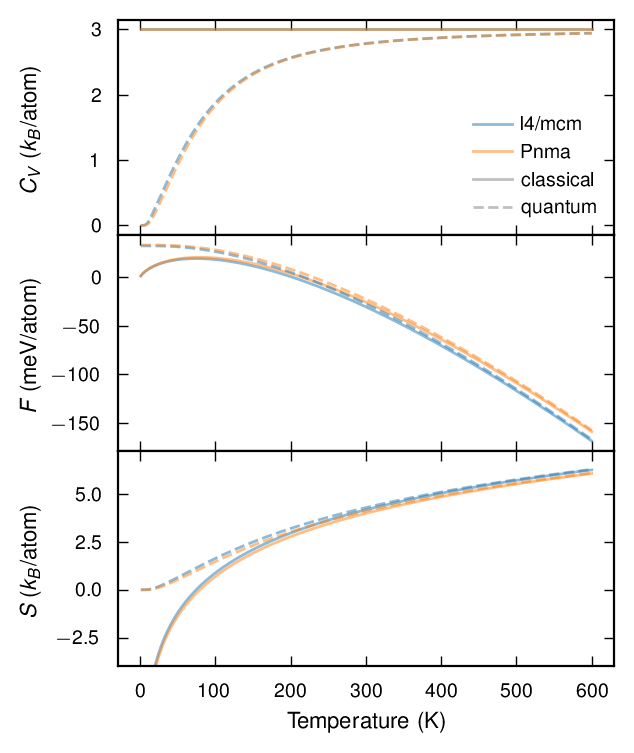

In [13]:
fig, axes = plt.subplots(
    figsize=(3.2, 4.2),
    dpi=200,
    nrows=3,
    sharex=True,
)

volsc = 1.0

# energy difference at zero K
structure = get_structure(phonons['BaZrS3-spg140-I4mcm'][volsc])
structure.calc = CPUNEP(model_filename)
energy_difference = structure.get_potential_energy() / len(structure)
print(energy_difference)
structure = get_structure(phonons['BaZrS3-spg62-Pnma'][volsc])
structure.calc = CPUNEP(model_filename)
energy_difference -= structure.get_potential_energy() / len(structure)
print(energy_difference)

for classical in dfs_thermo:
    for sname in dfs_thermo[classical]:
        df = dfs_thermo[classical][sname][1.0]
        kwargs = dict(
            alpha=0.5,
            label=labels[sname] if classical else '',
            color=colors[sname],
            ls='-' if classical else '--',
        )
        axes[0].plot(df.temperature, df.heat_capacity_kB, **kwargs)
        axes[1].plot(df.temperature, 1e3 * df.free_energy_eV, **kwargs)
        axes[2].plot(df.temperature, df.entropy_kB, **kwargs)

ax = axes[0]
ax.plot(np.nan, np.nan, '-', color='0.5', alpha=0.5, label='classical')
ax.plot(np.nan, np.nan, '--', color='0.5', alpha=0.5, label='quantum')

axes[0].set_ylabel('$C_V$ ($k_B$/atom)')
axes[1].set_ylabel('$F$ (meV/atom)')
axes[2].set_ylabel('$S$ ($k_B$/atom)')
axes[2].set_ylim(bottom=-4)
axes[-1].set_xlabel('Temperature (K)')

axes[0].legend()

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

In [42]:

dfs_thermo[False]['BaZrS3-spg140-I4mcm'][1.0]

,free_energy,entropy,heat_capacity,temperature,free_energy_eV,entropy_kB,heat_capacity_kB
0,31.197149,0.000189,0.000600,1,0.032334,0.000002,0.000007
1,31.197149,0.001605,0.004963,2,0.032334,0.000019,0.000060
2,31.197145,0.005775,0.018918,3,0.032334,0.000069,0.000228
3,31.197135,0.015619,0.057646,4,0.032334,0.000188,0.000693
4,31.197110,0.037503,0.156305,5,0.032334,0.000451,0.001880
...,...,...,...,...,...,...,...
595,-158.980722,521.163586,244.540266,596,-0.164772,6.268150,2.941140
596,-159.502091,521.573558,244.556211,597,-0.165312,6.273081,2.941332
597,-160.023869,521.982871,244.572079,598,-0.165853,6.278003,2.941523
598,-160.546057,522.391526,244.587870,599,-0.166394,6.282918,2.941712


In [36]:
dfs_thermo[False]['BaZrS3-spg62-Pnma'][1.0].free_energy-dfs_thermo[False]['BaZrS3-spg62-Pnma'][1.0].free_energy

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
595    0.0
596    0.0
597    0.0
598    0.0
599    0.0
Name: free_energy, Length: 600, dtype: float64

/var/folders/z6/b_jzphk53190vbrxr2tb1l980000gn/T/ipykernel_11879/713614840.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


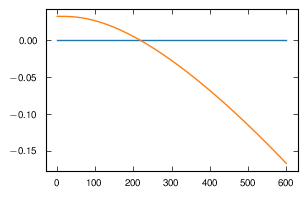

In [52]:
plt.plot(dfs_thermo[False]['BaZrS3-spg62-Pnma'][1.0].temperature, dfs_thermo[False]['BaZrS3-spg62-Pnma'][1.0].free_energy_eV-dfs_thermo[False]['BaZrS3-spg62-Pnma'][1.0].free_energy_eV)
plt.plot(dfs_thermo[False]['BaZrS3-spg140-I4mcm'][1.0].temperature, dfs_thermo[False]['BaZrS3-spg140-I4mcm'][1.0].free_energy_eV)
plt.legend()

In [68]:
import yaml
import pandas as pd
with open ('/Users/prakriti/2024_BaZrS3_Phase_Transitions/thermal_props/BaZrS3_140.in_NEP_thermal_properties') as f:
    tetra = yaml.safe_load(f)
df = pd.DataFrame(tetra['thermal_properties'])
df

,temperature,free_energy,entropy,heat_capacity,energy
0,0.0,30.353726,0.000000,0.000000,30.353726
1,10.0,30.352524,0.688597,3.146410,30.359410
2,20.0,30.314407,8.308465,22.523730,30.480576
3,30.0,30.167812,21.592080,44.420581,30.815574
4,40.0,29.874638,37.312529,65.755636,31.367139
...,...,...,...,...,...
96,960.0,-376.432194,643.364322,247.632634,241.197555
97,970.0,-382.878690,645.930676,247.669237,243.674066
98,980.0,-389.350721,648.471078,247.704739,246.150936
99,990.0,-395.848027,650.986044,247.739183,248.628157


In [70]:
with open ('/Users/prakriti/2024_BaZrS3_Phase_Transitions/thermal_props/BaZrS3_62.in_NEP_thermal_properties') as f:
    ortho = yaml.safe_load(f)
df = pd.DataFrame(tetra['thermal_properties'])
df

,temperature,free_energy,entropy,heat_capacity,energy
0,0.0,61.923975,0.000000,0.000000,61.923975
1,10.0,61.922565,0.757395,3.393799,61.930140
2,20.0,61.875967,10.819634,33.096994,62.092359
3,30.0,61.668966,31.956647,74.598444,62.627665
4,40.0,61.216315,59.333132,117.790623,63.589640
...,...,...,...,...,...
96,960.0,-727.830191,1260.664892,495.250690,482.408105
97,970.0,-740.462547,1265.797452,495.324225,487.360982
98,980.0,-753.145967,1270.878112,495.395548,492.314583
99,990.0,-765.879939,1275.907904,495.464745,497.268886


-2.041948699557067
-2.035762347869106


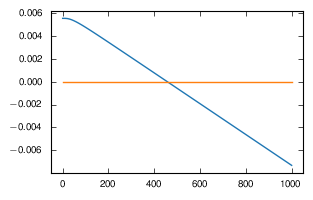

In [92]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read

sg_vals = [62, 140]


# constnts
EvTokJmol = 96.4853905398362

# collect all data
data_dict = dict()
for sg in sg_vals:
    prim = read(f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/thermal_props/BaZrS3_tilt_{sg}.in', format='aims')
    calculator = CPUNEP(model_filename)
    prim.calc = calculator
    E_0 = prim.get_potential_energy()/len(prim)
    print(E_0)
    # get F_vib
    with open(f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/thermal_props/BaZrS3_{sg}.in_NEP_thermal_properties') as f:
        loaded_data = yaml.safe_load(f)
    df = pd.DataFrame(loaded_data['thermal_properties'])
    temperatures = df.temperature.values
    F_vib = df['free_energy'].values / EvTokJmol / len(prim)
    F_tot = E_0 + F_vib
    data_dict[sg] = temperatures, F_tot

plt.plot(data_dict[140][0],data_dict[140][1]-data_dict[62][1])
plt.plot(data_dict[140][0],data_dict[62][1]-data_dict[62][1])

/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['transformation_matrix']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_rotation_matrix']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) i

-2.0470602224412957
-2.041052444693834


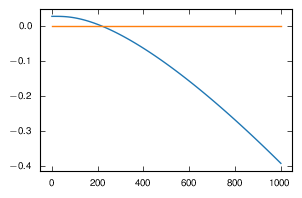

In [101]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS
sg_vals = [62, 140]


# constnts
EvTokJmol = 96.4853905398362

# collect all data
data_dict = dict()
for sg in sg_vals:
    structure = read(f'/Users/prakriti/2024_BaZrS3_Phase_Transitions/thermal_props/BaZrS3_tilt_{sg}.in', format='aims')
    calculator = CPUNEP(model_filename)
    fs = FixSymmetry(structure, symprec = 0.0000001)
    structure.set_constraint(fs)
    structure.calc = calculator

    ucf = UnitCellFilter(structure)
    dyn = BFGS(ucf, logfile='log.out', trajectory='test.traj')
    dyn.run(fmax=0.001, steps=1000)

    E_0 = structure.get_potential_energy()/structure.get_global_number_of_atoms()
    phonon = get_force_constants(structure, calculator, [4,4,4])
    phonon.run_mesh([20, 20, 20])
    phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)
    phonon.write_yaml_thermal_properties(filename = f'{sg}_NEP_thermal_properties.yaml')
    print(E_0)
    # get F_vib
    with open(f'{sg}_NEP_thermal_properties.yaml') as f:
        loaded_data = yaml.safe_load(f)
    df = pd.DataFrame(loaded_data['thermal_properties'])
    temperatures = df.temperature.values
    F_vib = df['free_energy'].values / EvTokJmol / len(prim)
    F_tot = E_0 + F_vib
    data_dict[sg] = temperatures, F_tot

plt.plot(data_dict[140][0],data_dict[62][1]-data_dict[140][1])
plt.plot(data_dict[140][0],data_dict[62][1]-data_dict[62][1])

-2.0410524571103825
-2.0470601933822095


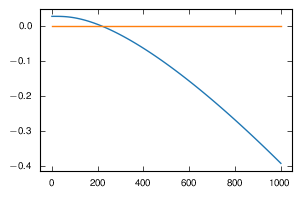

In [105]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS
sg_vals = ['BaZrS3-spg140-I4mcm.xyz','BaZrS3-spg62-Pnma.xyz']


# constnts
EvTokJmol = 96.4853905398362

# collect all data
data_dict = dict()
for sg in sg_vals:
    structure = read(f'{sg}')
    calculator = CPUNEP(model_filename)
    fs = FixSymmetry(structure, symprec = 0.0000001)
    structure.set_constraint(fs)
    structure.calc = calculator

    ucf = UnitCellFilter(structure)
    dyn = BFGS(ucf, logfile='log.out', trajectory='test.traj')
    dyn.run(fmax=0.001, steps=1000)

    E_0 = structure.get_potential_energy()/structure.get_global_number_of_atoms()
    phonon = get_force_constants(structure, calculator, [4,4,4])
    phonon.run_mesh([40, 40, 40])
    phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)
    phonon.write_yaml_thermal_properties(filename = f'{sg}_NEP_thermal_properties.yaml')
    print(E_0)
    # get F_vib
    with open(f'{sg}_NEP_thermal_properties.yaml') as f:
        loaded_data = yaml.safe_load(f)
    df = pd.DataFrame(loaded_data['thermal_properties'])
    temperatures = df.temperature.values
    F_vib = df['free_energy'].values / EvTokJmol / len(prim)
    F_tot = E_0 + F_vib
    data_dict[sg] = temperatures, F_tot

plt.plot(data_dict['BaZrS3-spg140-I4mcm.xyz'][0],data_dict['BaZrS3-spg62-Pnma.xyz'][1]-data_dict['BaZrS3-spg140-I4mcm.xyz'][1])
plt.plot(data_dict['BaZrS3-spg140-I4mcm.xyz'][0],data_dict['BaZrS3-spg62-Pnma.xyz'][1]-data_dict['BaZrS3-spg62-Pnma.xyz'][1])

/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['transformation_matrix']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_rotation_matrix']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) i

-2.0386431163394647
-2.0444280736470826


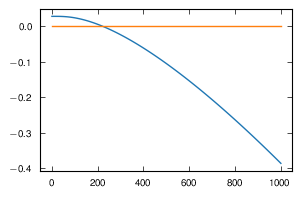

In [107]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS
sg_vals = ['BaZrS3-spg140-I4mcm.xyz','BaZrS3-spg62-Pnma.xyz']


# constnts
EvTokJmol = 96.4853905398362

# collect all data
data_dict = dict()
for sg in sg_vals:
    structure = read(f'{sg}')
    cell = structure.cell[:] * 1.0 ** (1 / 3)
    structure.set_cell(cell, scale_atoms=True)
    calculator = CPUNEP(model_filename)
    structure.calc = calculator
    structure.set_constraint(FixSymmetry(structure))
    relax_structure(structure, constant_volume=True)

    E_0 = structure.get_potential_energy()/structure.get_global_number_of_atoms()
    phonon = get_force_constants(structure, calculator, [4,4,4])
    phonon.run_mesh([40, 40, 40])
    phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)
    phonon.write_yaml_thermal_properties(filename = f'{sg}_NEP_thermal_properties.yaml')
    print(E_0)
    # get F_vib
    with open(f'{sg}_NEP_thermal_properties.yaml') as f:
        loaded_data = yaml.safe_load(f)
    df = pd.DataFrame(loaded_data['thermal_properties'])
    temperatures = df.temperature.values
    F_vib = df['free_energy'].values / EvTokJmol / len(prim)
    F_tot = E_0 + F_vib
    data_dict[sg] = temperatures, F_tot

plt.plot(data_dict['BaZrS3-spg140-I4mcm.xyz'][0],data_dict['BaZrS3-spg62-Pnma.xyz'][1]-data_dict['BaZrS3-spg140-I4mcm.xyz'][1])
plt.plot(data_dict['BaZrS3-spg140-I4mcm.xyz'][0],data_dict['BaZrS3-spg62-Pnma.xyz'][1]-data_dict['BaZrS3-spg62-Pnma.xyz'][1])